In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.homps import homps
from src.util import operators

In [3]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 50.0
T = 1/beta
gamma = 5.0
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30

# Convergence of the BCF

In [4]:
N_steps = 1000
taus = np.linspace(0, duration, N_steps)
N_terms = [13, 20, 50, 100, 1000]
alphas = np.empty((len(N_terms), N_steps), dtype=complex)
for i, N in enumerate(N_terms):
    g, w = debye_spectral_density.get_debye_coefficients(N, T, gamma, eta)
    alphas[i, :] = bath_correlation_function.alpha(taus, g, w)

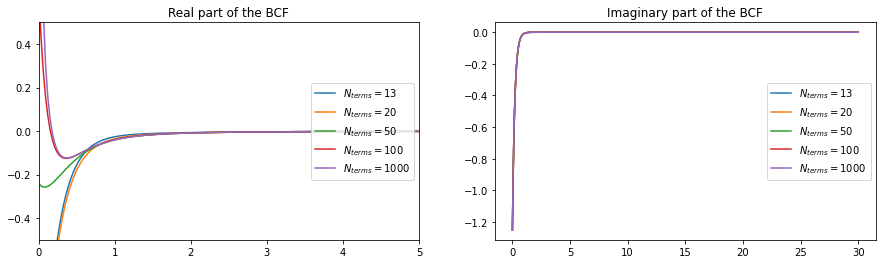

In [5]:
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
for i, N in enumerate(N_terms):
    axarray[0].plot(taus, np.real(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
    axarray[1].plot(taus, np.imag(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
axarray[0].legend(loc="right")
axarray[0].set_title("Real part of the BCF")
axarray[0].set_xlim(0, 5)
axarray[0].set_ylim(-0.5, 0.5)
axarray[1].legend(loc="right")
axarray[1].set_title("Imaginary part of the BCF")
plt.show()

In [6]:
N_terms = 13
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)
N_terms_noise = 200000
g_noise, w_noise = debye_spectral_density.get_debye_coefficients(N_terms_noise, T, gamma, eta)

In [7]:
print(g)

[-1.59834168e+00-1.25j -5.02972530e-04+0.j   -1.00785612e-03+0.j
 -1.51658610e-03+0.j   -2.03114703e-03+0.j   -2.55359894e-03+0.j
 -3.08610566e-03+0.j   -3.63096609e-03+0.j   -4.19064937e-03+0.j
 -4.76783507e-03+0.j   -5.36546004e-03+0.j   -5.98677346e-03+0.j
 -6.63540267e-03+0.j  ]


In [8]:
print(w)

[5.        +0.j 0.12566371+0.j 0.25132741+0.j 0.37699112+0.j
 0.50265482+0.j 0.62831853+0.j 0.75398224+0.j 0.87964594+0.j
 1.00530965+0.j 1.13097336+0.j 1.25663706+0.j 1.38230077+0.j
 1.50796447+0.j]


# HOMPS: Convergence in N_steps (without noise)

In [12]:
N_steps_list = [450, 500, 600, 2000]
N_trunc = 9

In [13]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-5,
    'method' : 'RK4',
    'use_precise_svd' : False,
}

In [131]:
psis_N_steps = []

for N_steps in N_steps_list:
    print("Computing N_steps =", N_steps)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_steps.append(my_homps.compute_realizations(1))
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_steps = 450
took 248.58419489860535 seconds.
Computing N_steps = 500
took 19.640939235687256 seconds.
Computing N_steps = 600
took 27.02607226371765 seconds.
Computing N_steps = 2000
took 89.62531113624573 seconds.


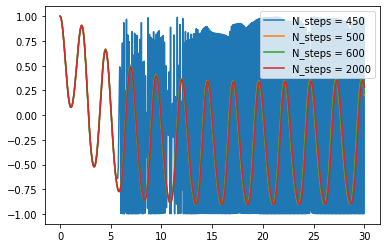

In [132]:
for i, N_steps in enumerate(N_steps_list):
    sigma_zs = compute_exp_val_nonlinear(psis_N_steps[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_steps = "+str(N_steps))
plt.legend()
plt.show()

N_steps=500 seems well converged!

# HOMPS: Convergence in N_trunc (without noise)

In [133]:
N_steps = 500
N_trunc_list = [6, 7, 8, 9]

In [134]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-5,
    'method' : 'RK4',
    'use_precise_svd' : False,
}

In [135]:
psis_N_trunc = []

for N_trunc in N_trunc_list:
    print("Computing N_trunc =", N_trunc)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_trunc.append(my_homps.compute_realizations(1))
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_trunc = 6
took 18.947871446609497 seconds.
Computing N_trunc = 7
took 21.77879047393799 seconds.
Computing N_trunc = 8
took 32.87240409851074 seconds.
Computing N_trunc = 9
took 37.95485973358154 seconds.


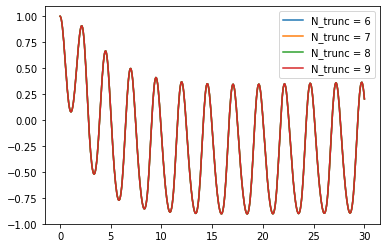

In [136]:
for i, N_trunc in enumerate(N_trunc_list):
    sigma_zs = compute_exp_val_nonlinear(psis_N_trunc[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_trunc = "+str(N_trunc))
plt.legend()
plt.show()

For N_trunc > 9 the numerical error is already too large. However, it seems to be converged really well.

# HOMPS: Convergence in N_trunc (with noise)

In [7]:
N_steps = 500
N_trunc_list = [6, 7, 8, 9]

In [8]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-5,
    'method' : 'RK4',
    'use_precise_svd' : False,
    'g_noise' : g_noise,
    'w_noise' : w_noise,
}
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc_list[0], options)
zts_debug = my_homps.generator.sample_process()

In [9]:
psis_N_trunc = []

for N_trunc in N_trunc_list:
    print("Computing N_trunc =", N_trunc)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_trunc.append(my_homps.compute_realizations(1, zts_debug=zts_debug))
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_trunc = 6
took 44.4724280834198 seconds.
Computing N_trunc = 7
took 47.569419622421265 seconds.
Computing N_trunc = 8
took 46.917357206344604 seconds.
Computing N_trunc = 9
took 51.30844235420227 seconds.


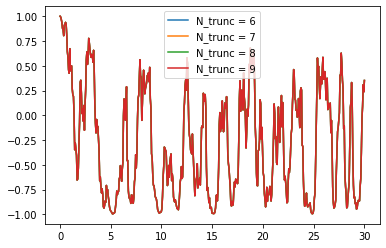

In [10]:
for i, N_trunc in enumerate(N_trunc_list):
    sigma_zs = compute_exp_val_nonlinear(psis_N_trunc[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_trunc = "+str(N_trunc))
plt.legend()
plt.show()

Well converged when N_trunc = 9

# HOMPS: Convergence in eps (without noise)

In [118]:
N_steps = 500
N_trunc = 9
eps_list = [1.e-3, 1.e-4, 1.e-5, 1.e-6]

In [119]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
    'use_precise_svd' : False,
}

In [120]:
psis_eps = []
average_bond_dims = []

for eps in eps_list:
    print("Computing eps =", eps)
    start = time.time()
    options['eps'] = eps
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_eps.append(my_homps.compute_realizations(1, collect_debug_info=True))
    average_bond_dims.append(my_homps.debug_info['average_bond_dim'][0])
    end = time.time()
    print("took", end-start, "seconds.")

Computing eps = 0.001
took 6.705924034118652 seconds.
Computing eps = 0.0001
took 15.85446810722351 seconds.
Computing eps = 1e-05
took 25.519872188568115 seconds.
Computing eps = 1e-06
took 47.39425086975098 seconds.


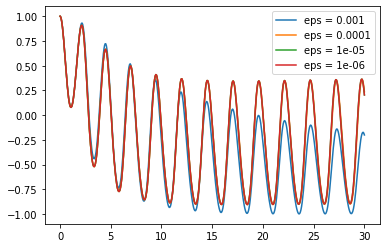

In [121]:
for i, eps in enumerate(eps_list):
    sigma_zs = compute_exp_val_nonlinear(psis_eps[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="eps = "+str(eps))
plt.legend()
plt.show()

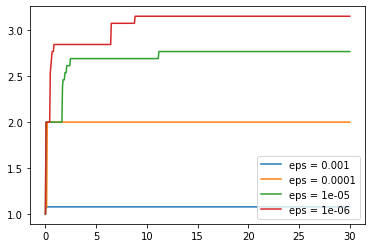

In [122]:
for i, eps in enumerate(eps_list):
    plt.plot(np.linspace(0, duration, N_steps), average_bond_dims[i], label="eps = "+str(eps))
plt.legend()
plt.show()

# HOMPS: Convergence in eps (with noise)

In [26]:
N_steps = 500
N_trunc = 9
eps_list = [1.e-3, 1.e-4, 1.e-5, 1.e-6]

In [27]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
    'use_precise_svd' : False,
    'g_noise' : g_noise,
    'w_noise' : w_noise,
}

In [28]:
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
zts_debug = my_homps.generator.sample_process()

In [17]:
psis_eps = []
average_bond_dims = []

for eps in eps_list:
    print("Computing eps =", eps)
    start = time.time()
    options['eps'] = eps
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_eps.append(my_homps.compute_realizations(1, zts_debug=zts_debug, collect_debug_info=True))
    average_bond_dims.append(my_homps.debug_info['average_bond_dim'][0])
    end = time.time()
    print("took", end-start, "seconds.")

Computing eps = 0.001
took 19.605241298675537 seconds.
Computing eps = 0.0001
took 40.06075429916382 seconds.
Computing eps = 1e-05
took 52.48275876045227 seconds.
Computing eps = 1e-06
took 71.77229022979736 seconds.


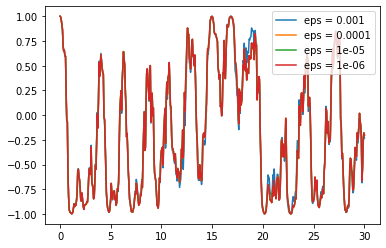

In [18]:
for i, eps in enumerate(eps_list):
    sigma_zs = compute_exp_val_nonlinear(psis_eps[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="eps = "+str(eps))
plt.legend()
plt.show()

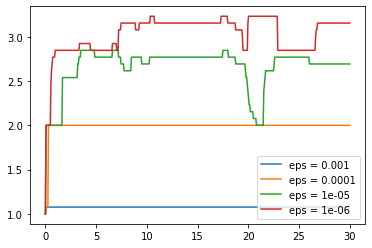

In [223]:
for i, eps in enumerate(eps_list):
    plt.plot(np.linspace(0, duration, N_steps), average_bond_dims[i], label="eps = "+str(eps))
plt.legend()
plt.show()

To make sure, one can choose 1.e-6, but 1.e-5 and 1.e-4 seem to be well converged as well.
For now, we will choose eps=1.e-5. Theres no point in trying higher values for chi_max, since the average bond dimension is below 5 even for eps=1.e-6.

# HOMPS: Convergence in chi_max (with noise)

In [29]:
N_steps = 500
N_trunc = 9
chi_max_list = [10, 20, 30]

In [30]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-6,
    'method' : 'RK4',
    'use_precise_svd' : False,
    'g_noise' : g_noise,
    'w_noise' : w_noise,
}

In [31]:
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
zts_debug = my_homps.generator.sample_process()

In [32]:
psis_chi_max = []
average_bond_dims = []

for chi_max in chi_max_list:
    print("Computing chi_max =", chi_max)
    start = time.time()
    options['chi_max'] = chi_max
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_chi_max.append(my_homps.compute_realizations(1, zts_debug=zts_debug, collect_debug_info=True))
    average_bond_dims.append(my_homps.debug_info['average_bond_dim'][0])
    end = time.time()
    print("took", end-start, "seconds.")

Computing chi_max = 10
took 45.037307262420654 seconds.
Computing chi_max = 20
took 37.86737656593323 seconds.
Computing chi_max = 30
took 37.09593176841736 seconds.


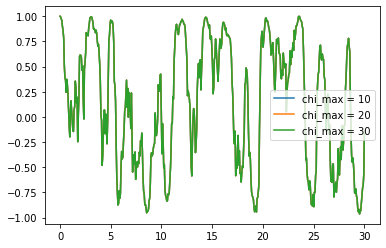

In [34]:
for i, chi_max in enumerate(chi_max_list):
    sigma_zs = compute_exp_val_nonlinear(psis_chi_max[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="chi_max = "+str(chi_max))
plt.legend()
plt.show()

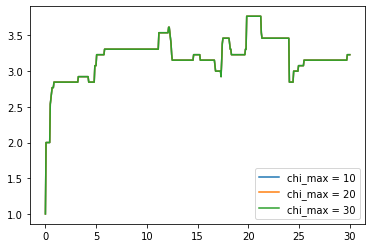

In [35]:
for i, chi_max in enumerate(chi_max_list):
    plt.plot(np.linspace(0, duration, N_steps), average_bond_dims[i], label="chi_max = "+str(chi_max))
plt.legend()
plt.show()

Converged.

# HOMPS: Convergence in N_terms (without noise)

In [21]:
N_steps = 500
N_trunc = 9
N_terms_list = [13, 15, 17, 20]

In [22]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-5,
    'method' : 'RK4',
    'use_precise_svd' : False,
}

In [23]:
psis_N_terms = []
average_bond_dims = []

for N_terms in N_terms_list:
    g_prime, w_prime = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)
    print("Computing N_terms =", N_terms)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g_prime, w_prime, h, L, duration, N_steps, N_trunc, options)
    psis_N_terms.append(my_homps.compute_realizations(1, collect_debug_info=True))
    average_bond_dims.append(my_homps.debug_info['average_bond_dim'][0])
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_terms = 13
took 19.512320280075073 seconds.
Computing N_terms = 15
took 25.870238780975342 seconds.
Computing N_terms = 17
took 34.226797580718994 seconds.
Computing N_terms = 20
took 48.30915713310242 seconds.


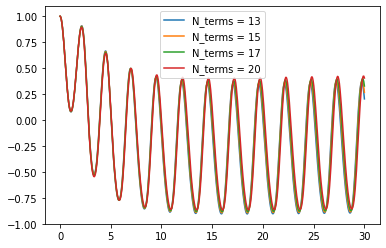

In [145]:
for i, N_terms in enumerate(N_terms_list):
    sigma_zs = compute_exp_val_nonlinear(psis_N_terms[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_terms = "+str(N_terms))
plt.legend()
plt.show()

Seems (relatively) converged. Deviations are only visible at t >= 15, where we expect them to average out anyway.

# Full run (non-linear HOMPS)

In [14]:
def doFullRun(N_samples=100, N_terms=13, N_steps=1000, N_trunc=9, options={}):
    g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    result = my_homps.compute_realizations(N_samples=N_samples, progressBar=tqdm)
    return result

### Using high number of terms (N_terms = 20)

In [15]:
N_samples = 100
N_terms = 20
N_steps = 1000
N_trunc = 9
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-5,
    'method' : 'RK4',
    'use_precise_svd' : False,
    'g_noise' : g_noise,
    'w_noise' : w_noise,
}
psis_100 = doFullRun(N_samples, N_terms, N_steps, N_trunc, options)

  0%|          | 0/100 [00:00<?, ?it/s]

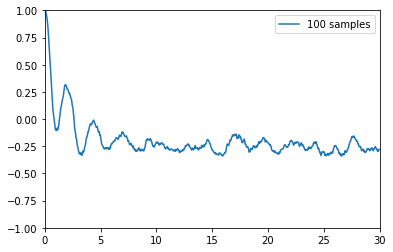

In [16]:
sigma_zs_100 = compute_exp_val_nonlinear(psis_100, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.legend()
plt.ylim(-1., 1)
plt.xlim(0, duration)
plt.show()

In [56]:
#N_terms = 13
N_terms = 13
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)

In [57]:
#N_steps = 500
#N_trunc = 9
#
#options = {
#    'linear' : False,
#    'use_noise' : True,
#    'chi_max' : 10,
#    'eps' : 1.e-5,
#    'method' : 'RK4',
#    'use_precise_svd' : False,
#    'g_noise' : g_noise,
#    'w_noise' : w_noise,
#}

N_steps = 1000
N_trunc = 9

options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-5,
    'method' : 'RK4',
    'use_precise_svd' : False,
    'g_noise' : g_noise,
    'w_noise' : w_noise,
}

In [58]:
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)

In [59]:
psis_100 = my_homps.compute_realizations(N_samples=100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

detected keyboard interrupt. Returning 54 realizations!


In [64]:
sigma_zs_100 = compute_exp_val_nonlinear(psis_100, sigma_z)
#average_bond_dims = my_homps.debug_info['average_bond_dims']

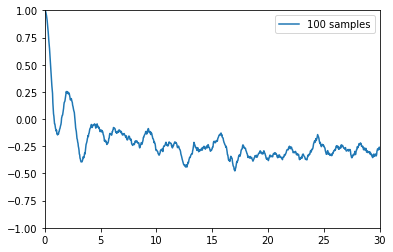

In [65]:
# using 1000 N_steps, chi_max = 10, N_terms=13, eps=1.e-5.
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.legend()
plt.ylim(-1., 1)
plt.xlim(0, duration)
plt.show()

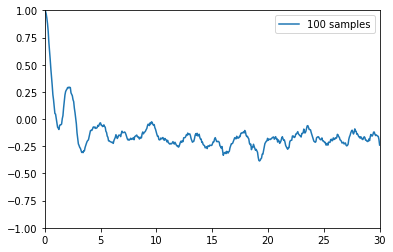

In [23]:
# using 200.000 noise and memory terms
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.legend()
plt.ylim(-1., 1)
plt.xlim(0, duration)
plt.show()

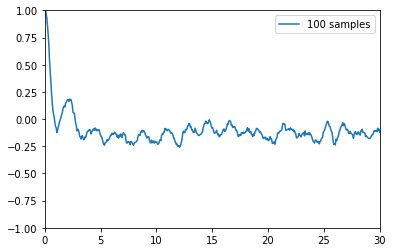

In [231]:
# using 200.000 noise terms
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.legend()
plt.ylim(-1., 1)
plt.xlim(0, duration)
plt.show()

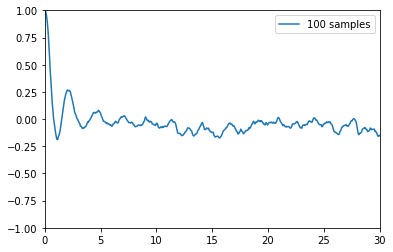

In [162]:
# using 13 noise terms
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.legend()
plt.ylim(-1., 1)
plt.xlim(0, duration)
plt.show()

# Full run (linear HOMPS)

In [40]:
N_terms = 13
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)

In [42]:
N_steps = 500
N_trunc = 9

options = {
    'linear' : True,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-5,
    'method' : 'RK4',
    'use_precise_svd' : False,
    'g_noise' : g_noise,
    'w_noise' : w_noise,
}

In [43]:
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)

In [235]:
psis_100 = my_homps.compute_realizations(N_samples=100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

In [238]:
sigma_zs_100 = compute_exp_val_linear(psis_100, sigma_z)
#average_bond_dims = my_homps.debug_info['average_bond_dims']

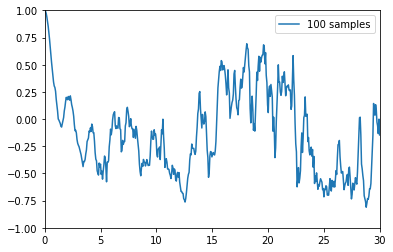

In [239]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.legend()
plt.ylim(-1., 1)
plt.xlim(0, duration)
plt.show()

# Debugging HOMPS: Looking at the memory

In [38]:
N_terms = 20
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)

In [39]:
N_steps = 500
N_trunc = 9

options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-5,
    'method' : 'RK4',
    'use_precise_svd' : False,
    'g_noise' : g_noise,
    'w_noise' : w_noise,
}

In [256]:
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
zts_debug = my_homps.generator.sample_process()

In [262]:
psis_debug = my_homps.compute_realizations(1, zts_debug=zts_debug, collect_debug_info=True)

In [263]:
memory = my_homps.debug_info['memory']

In [264]:
print(memory.shape)

(1, 500, 13)


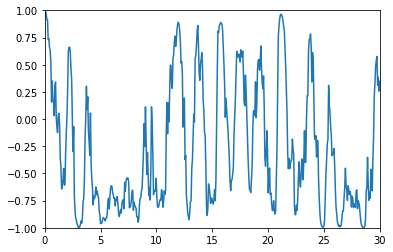

In [260]:
sigma_zs = compute_exp_val_nonlinear(psis_debug, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs)
plt.ylim(-1., 1)
plt.xlim(0, duration)
plt.show()

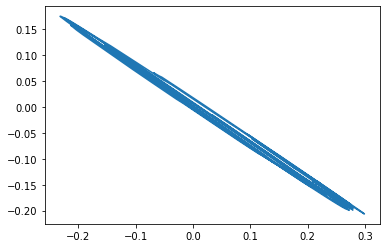

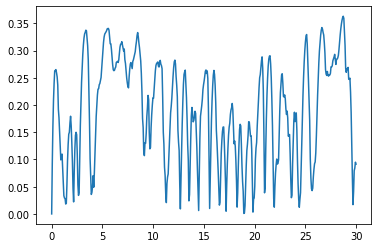

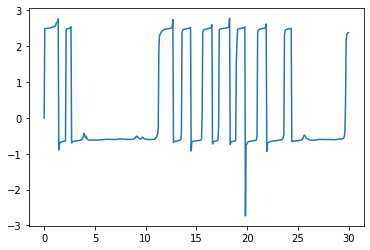

In [261]:
mem_total = np.sum(memory, axis=2)[0, :]
plt.plot(np.real(mem_total), np.imag(mem_total))
plt.show()
plt.plot(np.linspace(0, duration, N_steps), np.abs(np.sum(memory, axis=2))[0, :])
plt.show()
plt.plot(np.linspace(0, duration, N_steps), np.angle(np.sum(memory, axis=2))[0, :])
plt.show()

In [96]:
noise_g, noise_w = debye_spectral_density.get_debye_coefficients(1000, T, gamma, eta)

In [101]:
hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=True, chimax=chimax, epsilon=eps, N_krylov=N_krylov, method='RK4', noise_g=noise_g, noise_w=noise_w)

In [102]:
psis_100 = hierarchy.compute_realizations(N_samples=100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

Now takes ~12 seconds per realization

Takes ~5:00 minutes per realization for chi_max = 10,
and ~2:20 minutes per realization for chi_max = 3 (TDVP)

Takes ~5 minutes per realization for chi_max = 10 (RK4)

In [103]:
sigma_zs_100 = compute_exp_val_nonlinear(psis_100, sigma_z)

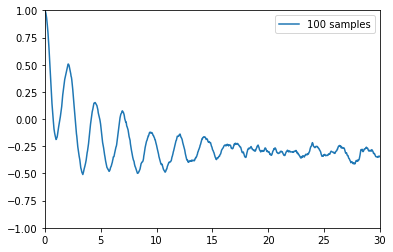

In [104]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.legend()
plt.ylim(-1., 1)
plt.xlim(0, duration)
plt.show()

# Does ordering the expansion coefficients help?

In [8]:
N_terms = 13
N_terms_noise = 200000
g_noise, w_noise = debye_spectral_density.get_debye_coefficients(N_terms_noise, T, gamma, eta)
g, w = g_noise[:N_terms], w_noise[:N_terms]

In [9]:
piv = np.flip(np.argsort(np.abs(g_noise)))
g_noise_ordered, w_noise_ordered = g_noise[piv], w_noise[piv]
g_ordered, w_ordered = g_noise_ordered[:N_terms], w_noise_ordered[:N_terms]

## HOMPS: Convergence in N_steps (without noise)

In [10]:
N_steps_list = [1000]
N_trunc = 9

In [11]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-5,
    'method' : 'RK4',
    'use_precise_svd' : False,
}

In [12]:
psis_N_steps = []

for N_steps in N_steps_list:
    print("Computing N_steps =", N_steps)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g_ordered, w_ordered, h, L, duration, N_steps, N_trunc, options)
    psis_N_steps.append(my_homps.compute_realizations(1))
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_steps = 1000
detected keyboard interrupt.
took 2.712674856185913 seconds.


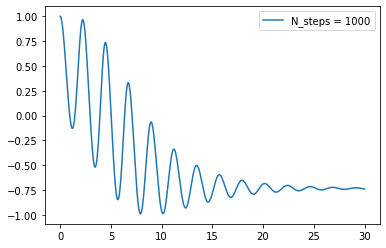

In [14]:
for i, N_steps in enumerate(N_steps_list):
    sigma_zs = compute_exp_val_nonlinear(psis_N_steps[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_steps = "+str(N_steps))
plt.legend()
plt.show()

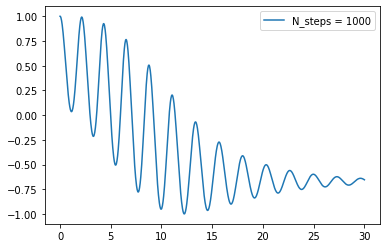

In [37]:
for i, N_steps in enumerate(N_steps_list):
    sigma_zs = compute_exp_val_nonlinear(psis_N_steps[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_steps = "+str(N_steps))
plt.legend()
plt.show()

## HOMPS: Convergence in N_trunc (without noise)

In [38]:
N_steps = 1000
N_trunc_list = [6, 7, 8, 9]

In [39]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-5,
    'method' : 'RK4',
    'use_precise_svd' : False,
}

In [40]:
psis_N_trunc = []

for N_trunc in N_trunc_list:
    print("Computing N_trunc =", N_trunc)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g_ordered, w_ordered, h, L, duration, N_steps, N_trunc, options)
    psis_N_trunc.append(my_homps.compute_realizations(1))
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_trunc = 6
took 100.15282464027405 seconds.
Computing N_trunc = 7
took 119.18791651725769 seconds.
Computing N_trunc = 8
took 139.00062441825867 seconds.
Computing N_trunc = 9
took 163.20948004722595 seconds.


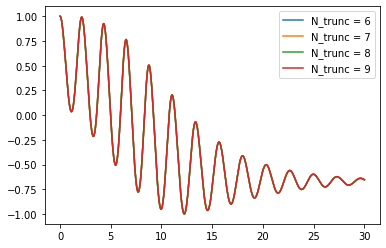

In [41]:
for i, N_trunc in enumerate(N_trunc_list):
    sigma_zs = compute_exp_val_nonlinear(psis_N_trunc[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_trunc = "+str(N_trunc))
plt.legend()
plt.show()

## HOMPS: Convergence in eps (without noise)

In [47]:
N_steps = 1000
N_trunc = 9
eps_list = [1.e-3, 1.e-4, 1.e-5, 1.e-6]

In [48]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
    'use_precise_svd' : False,
}

In [49]:
psis_eps = []
average_bond_dims = []

for eps in eps_list:
    print("Computing eps =", eps)
    start = time.time()
    options['eps'] = eps
    my_homps = homps.HOMPS_Engine(g_ordered, w_ordered, h, L, duration, N_steps, N_trunc, options)
    psis_eps.append(my_homps.compute_realizations(1, collect_debug_info=True))
    average_bond_dims.append(my_homps.debug_info['average_bond_dim'][0])
    end = time.time()
    print("took", end-start, "seconds.")

Computing eps = 0.001
took 30.828130960464478 seconds.
Computing eps = 0.0001
took 51.58531713485718 seconds.
Computing eps = 1e-05
took 89.55548238754272 seconds.
Computing eps = 1e-06
took 233.6398446559906 seconds.


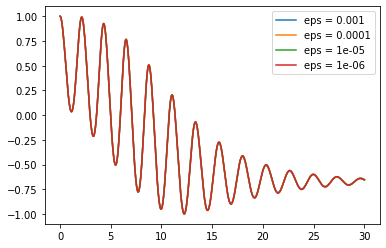

In [50]:
for i, eps in enumerate(eps_list):
    sigma_zs = compute_exp_val_nonlinear(psis_eps[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="eps = "+str(eps))
plt.legend()
plt.show()

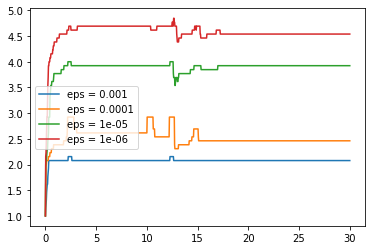

In [51]:
for i, eps in enumerate(eps_list):
    plt.plot(np.linspace(0, duration, N_steps), average_bond_dims[i], label="eps = "+str(eps))
plt.legend()
plt.show()

## HOMPS: Convergence in eps (with noise)

In [12]:
N_steps = 1000
N_trunc = 9
eps_list = [1.e-3, 1.e-4, 1.e-5, 1.e-6]

In [16]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
    'use_precise_svd' : False,
    'g_noise' : g_noise_ordered,
    'w_noise' : w_noise_ordered,
}

In [14]:
my_homps = homps.HOMPS_Engine(g_ordered, w_ordered, h, L, duration, N_steps, N_trunc, options)
zts_debug = my_homps.generator.sample_process()

In [17]:
psis_eps = []
average_bond_dims = []

for eps in eps_list:
    print("Computing eps =", eps)
    start = time.time()
    options['eps'] = eps
    my_homps = homps.HOMPS_Engine(g_ordered, w_ordered, h, L, duration, N_steps, N_trunc, options)
    psis_eps.append(my_homps.compute_realizations(1, zts_debug=zts_debug, collect_debug_info=True))
    average_bond_dims.append(my_homps.debug_info['average_bond_dim'][0])
    end = time.time()
    print("took", end-start, "seconds.")

Computing eps = 0.001
took 213.24471163749695 seconds.
Computing eps = 0.0001
took 225.07800579071045 seconds.
Computing eps = 1e-05
took 327.9450023174286 seconds.
Computing eps = 1e-06
took 532.7596714496613 seconds.


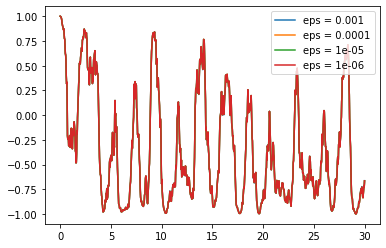

In [18]:
for i, eps in enumerate(eps_list):
    sigma_zs = compute_exp_val_nonlinear(psis_eps[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="eps = "+str(eps))
plt.legend()
plt.show()

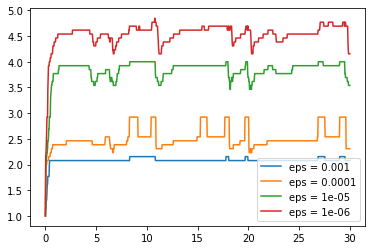

In [19]:
for i, eps in enumerate(eps_list):
    plt.plot(np.linspace(0, duration, N_steps), average_bond_dims[i], label="eps = "+str(eps))
plt.legend()
plt.show()

# Full run (non-linear HOMPS)

In [14]:
def doFullRun_ordered(N_samples=100, N_terms=13, N_steps=1000, N_trunc=9, options={}):
    g_ordered, w_ordered = g_noise_ordered[:N_terms], w_noise_ordered[:N_terms]
    my_homps = homps.HOMPS_Engine(g_ordered, w_ordered, h, L, duration, N_steps, N_trunc, options)
    result = my_homps.compute_realizations(N_samples=N_samples, progressBar=tqdm)
    return result

In [56]:
N_samples = 100
N_terms = 10
N_steps = 1000
N_trunc = 9
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
    'use_precise_svd' : False,
    'g_noise' : g_noise,
    'w_noise' : w_noise,
}
psis_100 = doFullRun_ordered(N_samples, N_terms, N_steps, N_trunc, options)

  0%|          | 0/100 [00:00<?, ?it/s]

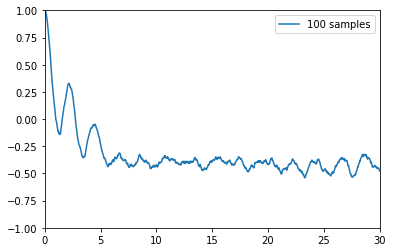

In [58]:
sigma_zs_100 = compute_exp_val_nonlinear(psis_100, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.legend()
plt.ylim(-1., 1)
plt.xlim(0, duration)
plt.show()

In [ ]:
N_samples = 100
N_terms = 13
N_steps = 1000
N_trunc = 9
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
    'use_precise_svd' : False,
    'g_noise' : g_noise,
    'w_noise' : w_noise,
}
psis_100 = doFullRun_ordered(N_samples, N_terms, N_steps, N_trunc, options)

  0%|          | 0/100 [00:00<?, ?it/s]

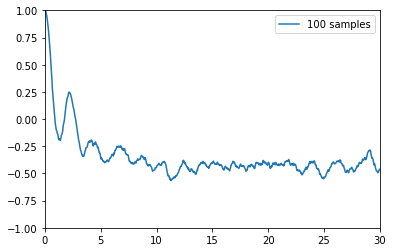

In [25]:
sigma_zs_100 = compute_exp_val_nonlinear(psis_100, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.legend()
plt.ylim(-1., 1)
plt.xlim(0, duration)
plt.show()